## Modelo de Regressão Logística - Desenvolvimento

In [27]:
from pathlib import Path
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)

input_path = r'D:\Github\Forked\crypto_technical_analysis\files\crypto_data_with_indicators.parquet'

dados = pd.read_parquet(input_path)

In [28]:
# Filter data for study
# symbols_filter = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'LTC-USD', 'DOGE-USD', 'MATIC-USD', 'LINK-USD', 'NEAR-USD']
symbols_filter = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'SOL-USD', 'ADA-USD', 'DOGE-USD', 'TON-USD', 'TRX-USD', 'AVAX-USD', 'SHIB-USD', 'DOT-USD', 'LINK-USD', 'BCH-USD', 'MATIC-USD', 'NEAR-USD', 'LTC-USD', 'UNI-USD', 'XMR-USD', 'XLM-USD', 'APT-USD', 'RNDR-USD', 'HBAR-USD']

dados = dados[dados['Symbol'].isin(symbols_filter)]

In [30]:
def data_clean(dados:pd.DataFrame, target_list:list, data_return:str):
    # Removing NA
    dados_treat = dados.dropna()

    # Substituindo valores infinitos por NaN
    dados_treat.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Removendo linhas com valores NaN
    dados_treat.dropna(inplace=True)

    # Removing columns that won't be use in the model
    # removing_cols = ['Symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
    removing_cols = ['Date', 'Symbol']

    # Define the target in a list of target (for futher iteration)
    dados_y = dados_treat[target_list]

    # Removing target from base to avoid data leakage
    dados_x = dados_treat.drop(dados_treat[target_list], axis=1)
    dados_x = dados_x.drop(dados_x[removing_cols], axis=1)

    if data_return == 'Y':
        return dados_y
    else:
        return dados_x

In [31]:
def get_target(dados_y:pd.DataFrame, col_target:str):
    return dados_y[col_target]

In [32]:

import preprocessing_data as preprocessing

target_list_bol =   [
    # boleanos
    'bl_target_10_7d','bl_target_15_7d','bl_target_20_7d','bl_target_25_7d',
    'bl_target_10_15d','bl_target_15_15d','bl_target_20_15d','bl_target_25_15d', 
    'bl_target_10_30d','bl_target_15_30d','bl_target_20_30d','bl_target_25_30d' 
]

target_list_val =   [
    # percentual
    'target_10_7d','target_15_7d','target_20_7d','target_25_7d',
    'target_10_15d','target_15_15d','target_20_15d','target_25_15d', 
    'target_10_30d','target_15_30d','target_20_30d','target_25_30d', 
]

remove_target_list = target_list_bol + target_list_val

dados_x = data_clean(dados, remove_target_list, 'X')
dados_y_all = data_clean(dados, remove_target_list, 'Y')

C:\Users\mathe\AppData\Local\Temp\ipykernel_16680\1057834492.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_treat.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\mathe\AppData\Local\Temp\ipykernel_16680\1057834492.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_treat.dropna(inplace=True)
C:\Users\mathe\AppData\Local\Temp\ipykernel_16680\1057834492.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_

In [33]:
dados_y = get_target(dados_y_all, target_list_bol[0])

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def split_data(dados_x:pd.DataFrame, dados_y:pd.DataFrame, test_size:float=0.3):

    # Getting dummies values. This way we can use categorical columns to train the models
    dummies = pd.get_dummies(dados_x)

    # Transform the data in numpy arrays
    X = np.array(dummies.values)
    y = np.array(dados_y.values)

    # This function returns X_train, X_test, y_train, y_test, in this order.
    # See below an example of the return 
    # X_train, X_test, y_train, y_test = split_data(dados_x, dados_y, 0.3)

    return train_test_split(X, y, test_size=test_size, random_state=45)

X_train, X_test, y_train, y_test = split_data(dados_x, dados_y, 0.3)

In [55]:
# Verificando o desbalanceamento de classes

# Supondo que 'y' seja o vetor de rótulos
print(pd.Series(y_train).value_counts(normalize=True))

0    0.827123
1    0.172877
Name: proportion, dtype: float64


In [56]:
# Balanceando as classes 
def balance_sample(X_train, y_train, type):

    from imblearn.under_sampling import RandomUnderSampler # pip install imblearn
    from imblearn.over_sampling import SMOTE

    # Reduzir amostra
    if type == 1:
        undersampler = RandomUnderSampler(random_state=42)
        return undersampler.fit_resample(X_train, y_train)

    # Aumentar amostra
    if type == 2:
        smote = SMOTE(random_state=42)
        return smote.fit_resample(X_train, y_train)
    
    # Sem mudanças
    if type == 0:
        return X_train, y_train   

In [57]:
# Rodar apenas se necessario fazer o balanceamento 
X_train, y_train = balance_sample(X_train, y_train, 1)

In [58]:
# Contar os valores 1
count_1 = np.count_nonzero(y_train == 1)

# Contar os valores 0
count_0 = np.count_nonzero(y_train == 0)

# Contar os valores 1
count_1t = np.count_nonzero(y_test == 1)

# Contar os valores 0
count_0t = np.count_nonzero(y_test == 0)

print(count_1, count_0)
print(count_1t, count_0t)

4324 4324
1869 8851


In [59]:
def norm_scale(X_norm_scale):

    # normalizando e padronizando os dados
    # MinMaxScaler é usado para normalizar as variáveis, e StandardScaler é usado para padronizar
    from sklearn.preprocessing import MinMaxScaler, StandardScaler

    # normalizando
    scaler = MinMaxScaler()
    scaler.fit(X_norm_scale)
    normalized_data = scaler.transform(X_norm_scale)
    # print(normalized_data)

    # Padronizando
    scaler = StandardScaler()
    scaler.fit(X_norm_scale)
    standardized_data = scaler.transform(X_norm_scale)
    # print(standardized_data)

    # print(standardized_data.shape)

    X_norm_scale = standardized_data
    
    return X_norm_scale

In [60]:
#Antes da normalização
X_train

array([[19.350130081176758, 20.555273056030273, 18.997766494750977, ...,
        False, False, False],
       [0.07207600027322769, 0.07256700098514557, 0.06972400099039078,
        ..., False, False, False],
       [0.11160700023174286, 0.11896699666976929, 0.11081700026988983,
        ..., False, False, False],
       ...,
       [9.699999645818025e-05, 0.00010099999781232327,
        9.500000305706635e-05, ..., False, False, False],
       [0.07811299711465836, 0.08279599994421005, 0.07661200314760208,
        ..., False, False, False],
       [271.2765197753906, 276.1597900390625, 265.41949462890625, ...,
        True, False, False]], dtype=object)

In [61]:
# # Normalizando datasets de treino e teste
X_train = norm_scale(X_train)
X_test = norm_scale(X_test)

In [62]:
# Depois da normalização
X_train

array([[-0.19487042, -0.19484796, -0.19481753, ..., -0.25730602,
        -0.12920564, -0.0493378 ],
       [-0.19772743, -0.19781332, -0.1976928 , ..., -0.25730602,
        -0.12920564, -0.0493378 ],
       [-0.19772157, -0.19780661, -0.19768656, ..., -0.25730602,
        -0.12920564, -0.0493378 ],
       ...,
       [-0.19773809, -0.19782382, -0.19770338, ..., -0.25730602,
        -0.12920564, -0.0493378 ],
       [-0.19772653, -0.19781184, -0.19769175, ..., -0.25730602,
        -0.12920564, -0.0493378 ],
       [-0.15753497, -0.15784305, -0.15738481, ...,  3.88642291,
        -0.12920564, -0.0493378 ]])

In [51]:
# Criando o modelo
model = LogisticRegression(class_weight='balanced',random_state=0,max_iter=1000)

# Treinando o modelo
model.fit(X_train, y_train)

clf = LogisticRegression(random_state=45,max_iter=1000).fit(X_train, y_train)

In [52]:
def eval_model(classifier, X_test, y_test):

    from sklearn.metrics import confusion_matrix
    from sklearn import metrics

    # Fazendo a previsão das classes
    y_pred2 = classifier.predict(X_test)

    # Avaliando o erro
    print('Confusion Matrix')
    print(confusion_matrix(y_test,y_pred2))

    # Avaliando o modelo 
    # score = model.score(X_test, y_test)
    score = metrics.accuracy_score(y_test, y_pred2)

    # Percentagem de acerto
    print('Acurácia:', score)

In [63]:
# Com a função de balanceamento de classe tipo 1
eval_model(clf, X_test, y_test)

Confusion Matrix
[[5218 3633]
 [ 681 1188]]
Acurácia: 0.5975746268656716


In [53]:
# Com a função de balanceamento de classe tipo 2
eval_model(clf, X_test, y_test)

Confusion Matrix
[[5218 3633]
 [ 681 1188]]
Acurácia: 0.5975746268656716


In [42]:
# Sem a função de balanceamento de classes
eval_model(clf, X_test, y_test)

Confusion Matrix
[[8811   40]
 [1849   20]]
Acurácia: 0.8237873134328358


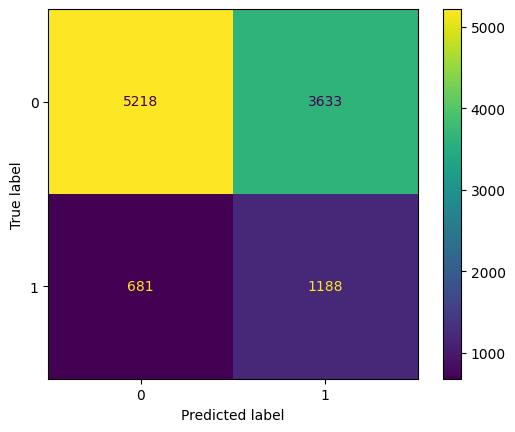

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

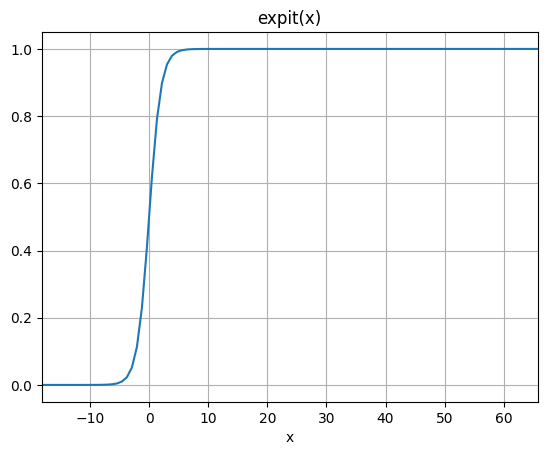

In [65]:
# Visualizando o gráfico

import matplotlib.pyplot as plt
from scipy.special import expit

x = np.linspace(X_train.min(), X_train.max(), 100)
y = expit(x)
plt.plot(x, y)
plt.grid()
plt.xlim(X_train.min(), X_train.max())
plt.xlabel('x')
plt.title('expit(x)')
plt.show()

In [236]:
def save_model(classifier, name_model:str):
    # Lib to save the model in a compressed way
    import joblib

    # Save the model that has been trained
    joblib.dump(classifier, name_model + '.joblib')

    print(f'Modelo savo no diretório atual com o nome de {name_model}.joblib')

In [237]:
def load_model(name_model:str):
    # Lib to save the model in a compressed way
    import joblib

    # Load the trained model
    clf_loaded = joblib.load(name_model + '.joblib')

    return clf_loaded

In [46]:
nome_modelo = 'logistic_regression_model_bl_target_10_7d'
save_model(clf, nome_modelo)

Modelo savo no diretório atual com o nome de logistic_regression_model_bl_target_10_7d.joblib
